# GEO Link Budget

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pylink
import SystemDefinition
from utils import Loader
import scipy
import scipy.stats as st
from scipy import interpolate
import pickle

import warnings
warnings.filterwarnings('ignore') # this prevents a warning that comes from the ITU library - need to check this

## Create the system description

### Satellite Configuration

In this analysis the satellite is setup in it's GEO configuration with Rx and Tx antennas which split a face of 6U CubeSat.  The 300 x 200 mm face is equally split between Rx and Tx giving an antenna aperture of 150 x 200 mm each.

A 5 W power amplifier is used.


### Channel Configuration

This analysis is for a geostationery orbit at an altitude of 35,786 km.  The inclincation is 0 for a circular orbit.  Static values are used channel loss.


### Groundstation Configuration

Some representative numbers have been used for the groundstation performance.  The main thing that will be varied in the analysis is the receive antenna size

### Import the configuration files

In [9]:
satellite_configuration = Loader.load_configuration('configs/satellite-geo.yaml')
channel_configuration = Loader.load_configuration('configs/channel-geo.yaml')
groundstation_configuration = Loader.load_configuration('configs/groundstation-tvdish.yaml')

## Find the achievable datarates for differing antenna sizes

In [4]:
# create elevation points to tests and prepopulate the outputs
rx_antenna_diameter = np.linspace(0.5, 5, 30)

rx_power = np.zeros(len(rx_antenna_diameter))
link_margin = np.zeros(len(rx_antenna_diameter))
datarate = np.zeros(len(rx_antenna_diameter))

# loop through each antenna diameter
for i in range(len(rx_antenna_diameter)):

    rx_antenna_aperture = np.pi * (rx_antenna_diameter[i]/2)**2
    groundstation_configuration['nominal']['rx']['antenna']['aperture'] = rx_antenna_aperture

    system = SystemDefinition.SystemDefinition( satellite_configuration,
                                                groundstation_configuration,
                                                channel_configuration,
                                                warn=False)
    rx_power[i], link_margin[i], datarate[i] = system.link_metrics()

### Plot the achievable datarates

<IPython.core.display.Javascript object>


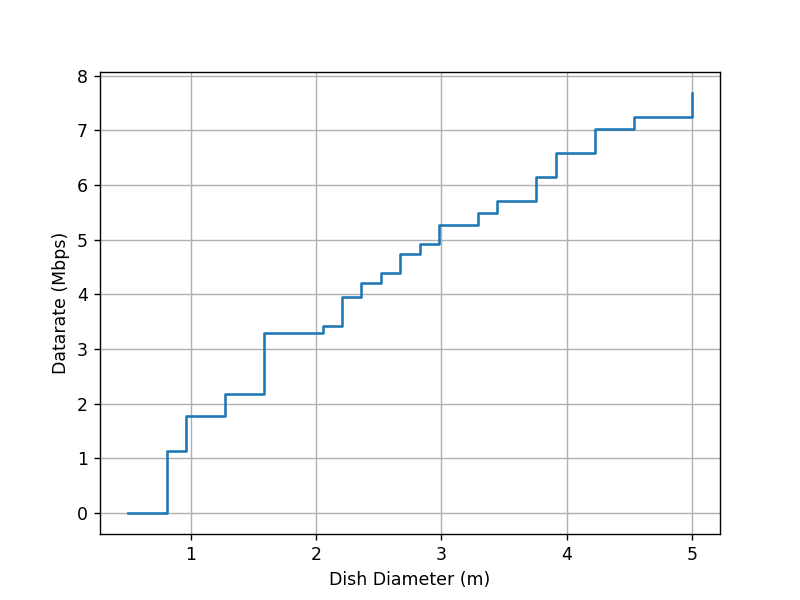

In [5]:
plt.figure()
plt.step(rx_antenna_diameter, datarate/1e6, where='post')
plt.ylabel('Datarate (Mbps)')
plt.xlabel('Dish Diameter (m)')
plt.title('')
plt.grid()
plt.show()

### Print the system details

This breaks down some system parameters for the most recent (and most optimistic) analysis case 

In [6]:
system.print_link_info('downlink')

Elevation (degress):             30
Slant Range (km):               38611.7
Antenna Angle (deg):            7.52756
Total Rx Noise Temperature (K): 421.614
Receiver Noise Temperature (K): 121.614
Noise Factor:                   1.41936
Noise Figure (dB):              1.52092
Transmit Power (dBW):             5
Transmit EIRP (dBW):            29.4115
UGPL (dB):                      204.585
Total Channel Loss (dB):        207.822
Link Margin (dB):               9.77375
Noise BW Loss (dB):             0  
C / N0 (dB):                    76.0099
Rx Power (dBW):                 -126.34
Rx N0 (dBW/Hz):                 -202.35
Eb / N0 (dB):                   16.979
Eb (dB):                        -185.371
Bitrate Hz (dB):                59.0309
=== Modulation: DVB-S2X ===
  Best Code:                    32APSK 7/9
  Transmit Spectral Efficiency: 3.072981
  Receive Spectral Efficiency:  3.841226
  Required Es/N0:               13.050000
  Required Eb/N0:               7.205301
  Achieved Datar

# Perform a Monte-Carlo Simulation

A Monte-Carlo simulation calculates the link performance many times each time drawing values from the statistical distribution of each parameter. By repeating this process many times the statistical performance overall can be determined.

The distributions for each element are defined in the associated configuration files. For example, the elevation is randomly varied between 5 $^{\circ}$ and 90 $^{\circ}$.  The slant range and the propagation losses using the ITU models are re-calculated for the selected elevation.  Each variable, (gain, noise figure, etc.) can have a statistical distribution assigned to it.

It could take a while to run the simulation...

In [12]:
mc_length = 1000
rx_antenna_diameter = np.linspace(0.5, 5, 40)

rx_power_mc = np.zeros((len(rx_antenna_diameter), 7))
link_margin_mc = np.zeros((len(rx_antenna_diameter), 7))
datarate_mc = np.zeros((len(rx_antenna_diameter), 7))

# loop through each elevation
for j in range(len(rx_antenna_diameter)):
    
    rx_power_mc_run = np.zeros(mc_length)
    link_margin_mc_run = np.zeros(mc_length)
    datarate_mc_run = np.zeros(mc_length)
    
    # update the receive antenna diameter
    rx_antenna_aperture = np.pi * (rx_antenna_diameter[j]/2)**2
    groundstation_configuration['nominal']['rx']['antenna']['aperture'] = rx_antenna_aperture
    
    # run through the Monte-Carlo iterations
    for i in range(mc_length):
        system = SystemDefinition.SystemDefinition( satellite_configuration,
                                                    groundstation_configuration,
                                                    channel_configuration,
                                                    monte_carlo=True,
                                                    warn=False)
        rx_power_mc_run[i], link_margin_mc_run[i], datarate_mc_run[i] = system.link_metrics()

    # find the signal statistics
    rx_power_mc[j] = system.find_confidence_intervals(rx_power_mc_run)
    link_margin_mc[j] = system.find_confidence_intervals(link_margin_mc_run)
    datarate_mc[j] = system.find_confidence_intervals(datarate_mc_run)

with open('geo_mc.pkl', 'wb') as f:
    pickle.dump([rx_antenna_diameter, rx_power_mc, link_margin_mc, datarate_mc], f)

In [14]:
with open('geo_mc.pkl', 'rb') as f:
    rx_antenna_diameter, rx_power_mc, link_margin_mc, datarate_mc = pickle.load(f)

### Plot the Results

We will plot the statistical data.  The median, 25%, 50% and 75% confidence intervals are shown.

Note that the distribution is not symmetric, ie. the skewness and kurtosis is non-zero.  Therefore, mean is not an appropriate measure of the peak of the probability density function.

<IPython.core.display.Javascript object>


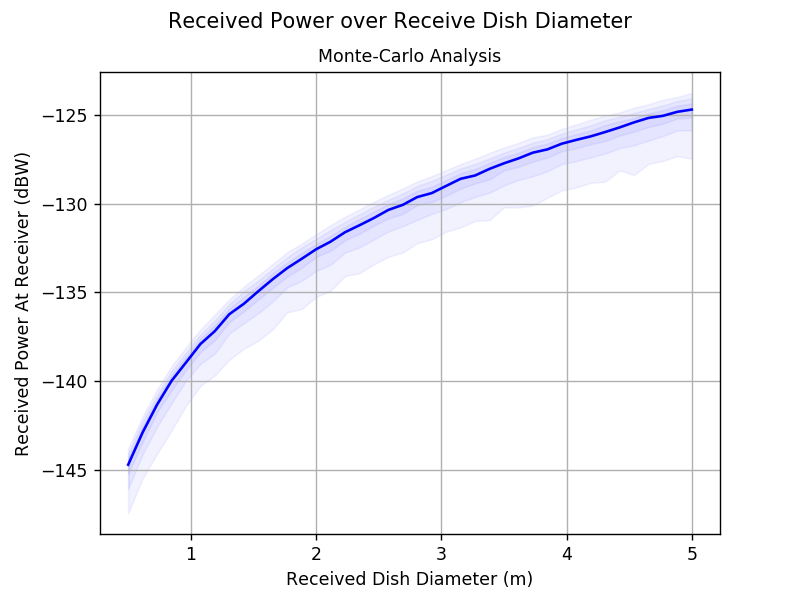

In [15]:
system.plot_confidence_intervals(rx_antenna_diameter, rx_power_mc, 
                                 ['Received Power over Receive Dish Diameter', 
                                  'Received Dish Diameter (m)',
                                  'Received Power At Receiver (dBW)'])

<IPython.core.display.Javascript object>


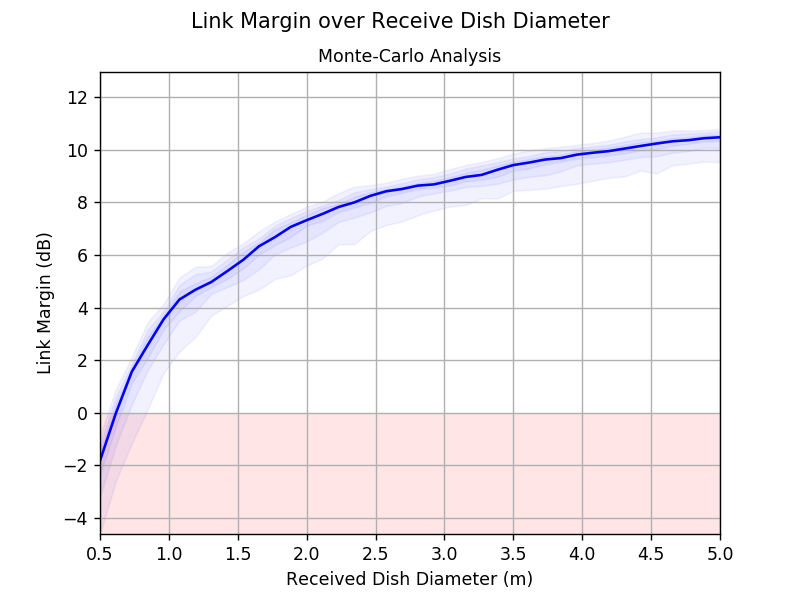

In [17]:
system.plot_confidence_intervals(rx_antenna_diameter, link_margin_mc, 
                                 ['Link Margin over Receive Dish Diameter', 
                                  'Received Dish Diameter (m)',
                                  'Link Margin (dB)'],
                                  negative_shade=True)

<IPython.core.display.Javascript object>


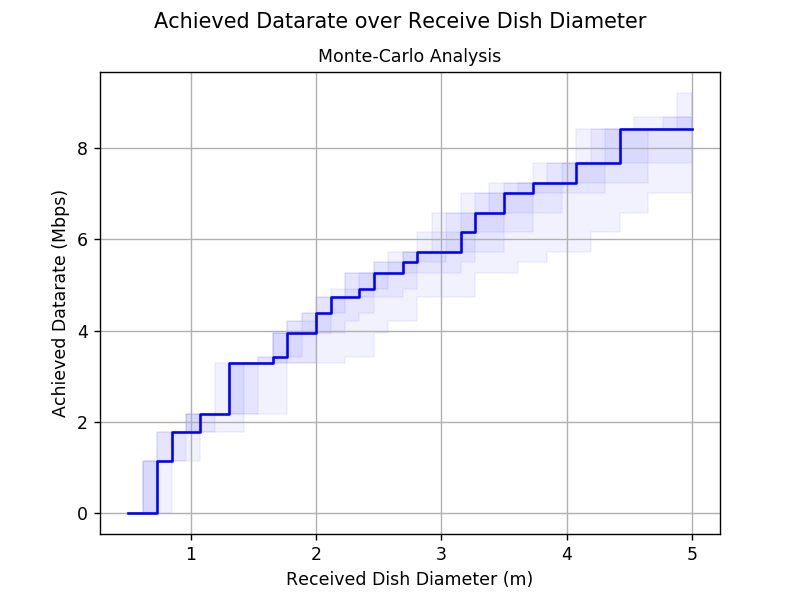

In [16]:
system.plot_confidence_intervals(rx_antenna_diameter, datarate_mc/1e6, 
                                 ['Achieved Datarate over Receive Dish Diameter', 
                                  'Received Dish Diameter (m)',
                                  'Achieved Datarate (Mbps)'],
                                  step=True)